In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection  import train_test_split
from sklearn.preprocessing   import LabelEncoder
from sklearn.metrics          import (classification_report,
                                         roc_auc_score,
                                         confusion_matrix,
                                         ConfusionMatrixDisplay)
from xgboost                  import XGBClassifier
import shap
import joblib

# Load master table and RFM scores
master = pd.read_csv('../data/processed/master_orders.csv',
                      parse_dates=['order_purchase_timestamp'])
rfm    = pd.read_csv('../data/processed/rfm_scores.csv')

print(f"Master: {master.shape}")
print(f"RFM:    {rfm.shape}")

Master: (96477, 26)
RFM:    (93357, 9)


In [19]:
REF_DATE = pd.Timestamp('2018-10-18')
CHURN_DAYS = 180  # customers inactive > 180 days = churned

# Build one row per customer with all features
customer_features = master.groupby('customer_unique_id').agg(

    # RFM base features
    recency        = ('order_purchase_timestamp',
                      lambda x: (REF_DATE - x.max()).days),
    frequency      = ('order_id',        'count'),
    monetary       = ('total_payment',   'sum'),

    # Order behaviour features
    avg_order_value= ('total_payment',   'mean'),
    avg_items      = ('item_count',      'mean'),
    avg_freight    = ('total_freight',   'mean'),
    installments   = ('installments',    'mean'),

    # Satisfaction features
    avg_review     = ('review_score',    'mean'),
    pct_late       = ('is_late',         'mean'),

    # Time features
    avg_delivery   = ('delivery_days',   'mean'),
    first_purchase = ('order_purchase_timestamp', 'min'),
    last_purchase  = ('order_purchase_timestamp', 'max')

).reset_index()

# Calculate customer lifespan in days
customer_features['lifespan_days'] = (
    customer_features['last_purchase'] -
    customer_features['first_purchase']
).dt.days

# DEFINE CHURN LABEL
customer_features['churned'] = (
    customer_features['recency'] > CHURN_DAYS
).astype(int)

print(f"Total customers: {len(customer_features):,}")
print(f"\nChurn breakdown:")
print(customer_features['churned'].value_counts())
print(f"\nChurn rate: {customer_features['churned'].mean()*100:.1f}%")

Total customers: 93,357

Churn breakdown:
churned
1    65962
0    27395
Name: count, dtype: int64

Churn rate: 70.7%


In [26]:
# Select features for the model
FEATURES = [
    'frequency', 'monetary',
    'avg_order_value', 'avg_items', 'avg_freight',
    'installments', 'avg_review', 'pct_late',
    'avg_delivery', 'lifespan_days'
]

X = customer_features[FEATURES].copy()
y = customer_features['churned']

# Fill any nulls with column median
X = X.fillna(X.median())

# Split 80/20 — stratify keeps same churn ratio in both splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size    = 0.2,
    random_state = 42,
    stratify     = y
)

print(f"Training set:  {X_train.shape}")
print(f"Test set:      {X_test.shape}")
print(f"\nChurn rate in train: {y_train.mean()*100:.1f}%")
print(f"Churn rate in test:  {y_test.mean()*100:.1f}%")
print("\n✓ Stratified split done — same ratio in both sets")

Training set:  (74685, 10)
Test set:      (18672, 10)

Churn rate in train: 70.7%
Churn rate in test:  70.7%

✓ Stratified split done — same ratio in both sets


In [27]:
# Handle class imbalance with scale_pos_weight
ratio = (y_train == 0).sum() / (y_train == 1).sum()

model = XGBClassifier(
    n_estimators      = 300,
    max_depth         = 5,
    learning_rate     = 0.05,
    subsample         = 0.8,
    colsample_bytree  = 0.8,
    scale_pos_weight  = ratio,   # handles imbalance
    random_state      = 42,
    eval_metric       = 'logloss',
    verbosity         = 0
)

print("Training XGBoost model...")
model.fit(X_train, y_train)
print("✓ Model trained!")

# Predictions
y_pred      = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
print(f"\n=== MODEL PERFORMANCE ===")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred,
      target_names=['Active', 'Churned']))

Training XGBoost model...
✓ Model trained!

=== MODEL PERFORMANCE ===
ROC-AUC Score: 0.8483

Classification Report:
              precision    recall  f1-score   support

      Active       0.56      0.78      0.65      5479
     Churned       0.89      0.74      0.81     13193

    accuracy                           0.75     18672
   macro avg       0.72      0.76      0.73     18672
weighted avg       0.79      0.75      0.76     18672



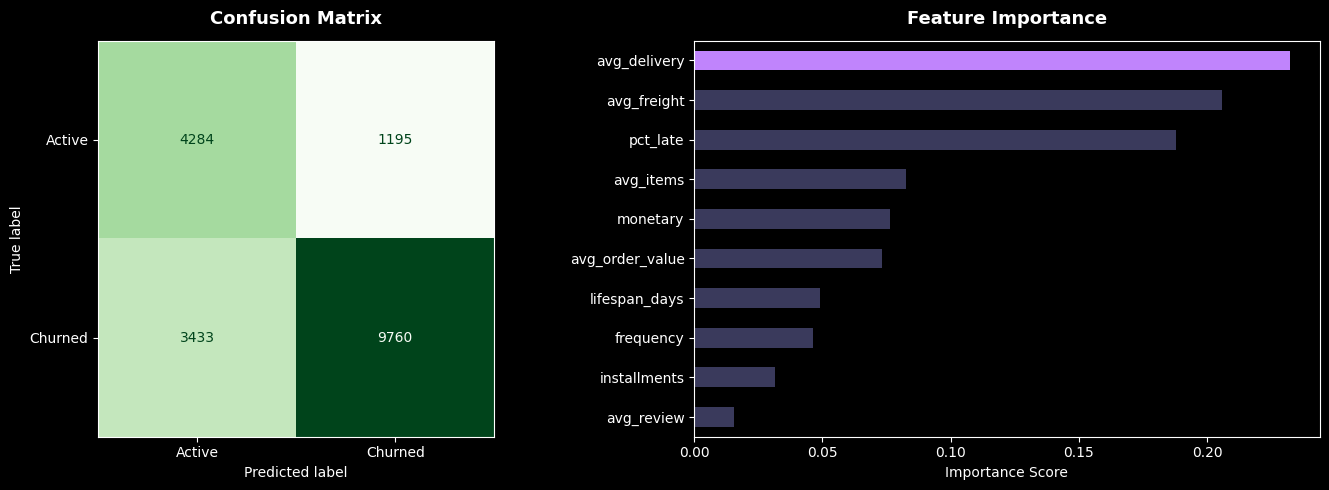

In [22]:
plt.style.use('dark_background')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

## Chart 1: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm,
         display_labels=['Active', 'Churned'])
disp.plot(ax=axes[0], colorbar=False, cmap='Greens')
axes[0].set_title('Confusion Matrix', fontsize=13,
                   fontweight='bold', pad=12)

## Chart 2: Feature Importance
feat_imp = pd.Series(
    model.feature_importances_,
    index=FEATURES
).sort_values(ascending=True)

colors_fi = ['#c084fc' if v == feat_imp.max()
              else '#3a3a5c' for v in feat_imp]
feat_imp.plot(kind='barh', ax=axes[1],
              color=colors_fi, edgecolor='none')
axes[1].set_title('Feature Importance', fontsize=13,
                   fontweight='bold', pad=12)
axes[1].set_xlabel('Importance Score')

plt.tight_layout()
plt.savefig('../docs/model_performance.png',
            dpi=150, bbox_inches='tight')
plt.show()

Calculating SHAP values...
✓ SHAP values calculated


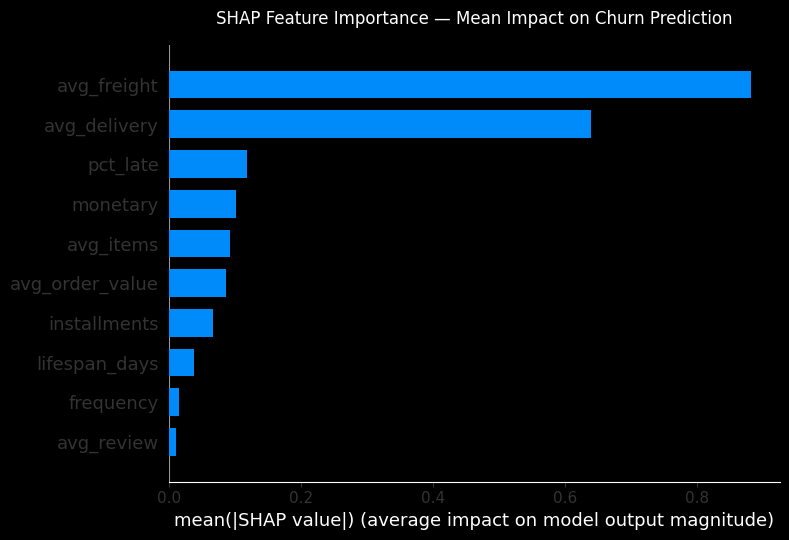

In [23]:
print("Calculating SHAP values...")
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
print("✓ SHAP values calculated")

# SHAP Summary Plot — shows impact of each feature
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_test,
    plot_type = 'bar',
    show      = False
)
plt.title('SHAP Feature Importance — Mean Impact on Churn Prediction',
         fontsize=12, pad=15)
plt.tight_layout()
plt.savefig('../docs/shap_summary.png',
            dpi=150, bbox_inches='tight')
plt.show()

Customer #42
Churn Probability : 41.2%
Prediction        : ACTIVE

Customer Profile:
                 32185
frequency         1.00
monetary         43.61
avg_order_value  43.61
avg_items         1.00
avg_freight      13.71
installments      1.00
avg_review        5.00
pct_late          0.00
avg_delivery     13.00
lifespan_days     0.00


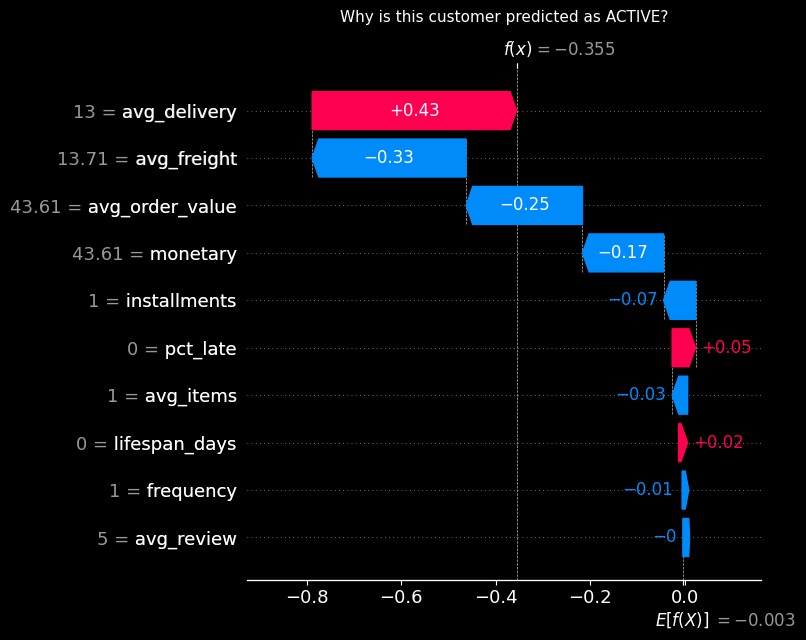

In [24]:
# Pick one customer from test set and explain their prediction
customer_idx = 42  # change this number to see different customers
customer_data = X_test.iloc[[customer_idx]]

churn_prob = model.predict_proba(customer_data)[0][1]
prediction = "CHURNED" if churn_prob > 0.5 else "ACTIVE"

print(f"Customer #{customer_idx}")
print(f"Churn Probability : {churn_prob*100:.1f}%")
print(f"Prediction        : {prediction}")
print(f"\nCustomer Profile:")
print(customer_data.T.to_string())

# Waterfall chart — shows each feature's contribution
shap_val_single = explainer(customer_data)
shap.plots.waterfall(shap_val_single[0], show=False)
plt.title(f'Why is this customer predicted as {prediction}?',
         fontsize=11, pad=12)
plt.tight_layout()
plt.savefig('../docs/shap_waterfall.png',
            dpi=150, bbox_inches='tight')
plt.show()

In [25]:
import joblib

# Save trained model
joblib.dump(model, '../models/churn_model.pkl')
print("✓ Saved: models/churn_model.pkl")

# Save feature list (dashboard needs this)
joblib.dump(FEATURES, '../models/feature_names.pkl')
print("✓ Saved: models/feature_names.pkl")

# Save customer features table (dashboard reads this)
customer_features.to_csv(
    '../data/processed/customer_features.csv',
    index=False
)
print("✓ Saved: data/processed/customer_features.csv")

# Final summary
print(f"""
=== MODEL SUMMARY ===
Algorithm     : XGBoost Classifier
Features      : {len(FEATURES)}
Training rows : {len(X_train):,}
Test rows     : {len(X_test):,}
ROC-AUC       : {roc_auc_score(y_test, y_pred_prob):.4f}
Churn rate    : {y.mean()*100:.1f}%
Model saved   : models/churn_model.pkl
""")

✓ Saved: models/churn_model.pkl
✓ Saved: models/feature_names.pkl
✓ Saved: data/processed/customer_features.csv

=== MODEL SUMMARY ===
Algorithm     : XGBoost Classifier
Features      : 10
Training rows : 74,685
Test rows     : 18,672
ROC-AUC       : 0.8483
Churn rate    : 70.7%
Model saved   : models/churn_model.pkl

